# 1. Загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn

In [2]:
train = pd.read_csv('Data/train.csv', low_memory=False)
train.index.name = 'Index'
X_train = train.loc[:, ~train.columns.isin(['casual', 'registered', 'count'])]
y_train = train.loc[:, train.columns.isin(['casual', 'registered', 'count'])]
X_test = pd.read_csv('Data/test.csv', low_memory=False)
X_test.index.name = 'Index'

# 2. Исследовательский анализ данных

In [3]:
#print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
#print("X_test shape:", X_test.shape)

In [4]:
#Exlore the size of the data sets 
print("train shape:", train.shape)
print("test shape:",  X_test.shape)

train shape: (10886, 12)
test shape: (6493, 9)


In [5]:
#First 5 rows of the train set
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
Index,,,,,,,,,,,,
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
#Variable data type 
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# 3. Инженерия признаков

In [7]:
#Create year, month, day, time columns
train['year'] = pd.to_datetime(train['datetime']).apply(lambda x : x.year)
train['month'] = pd.to_datetime(train['datetime']).apply(lambda x : x.month)
train['weekday'] = pd.to_datetime(train['datetime']).apply(lambda x : x.isoweekday())
train['hour'] = pd.to_datetime(train['datetime']).apply(lambda x : x.hour)
#Drop datetime column as no longer needed
train.drop(columns=['datetime'], inplace = True)

In [8]:
#Update season, weather columns to be more explicit
train['season'] = train['season'].map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
train['weather'] = train['weather'].map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [9]:
#Change below columns types to categorical
for col in ["hour","weekday","month","year", "season","weather","holiday","workingday"]:
    train[col] = train[col].astype("category")

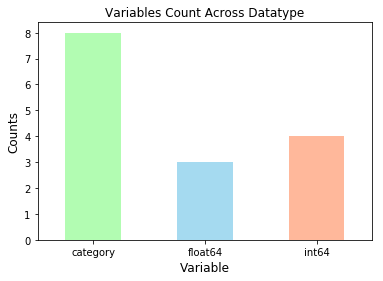

In [10]:
#Build a plot of varables data types distribution
dataTypeDf = pd.DataFrame(train.get_dtype_counts())
variables_distr_plot = dataTypeDf.plot(kind='bar', title="Variables Count Across Datatype" , 
                color=[['palegreen', 'skyblue', 'lightsalmon']], alpha=0.75, rot=0, legend=False)
variables_distr_plot.set_xlabel("Variable", fontsize=12)
variables_distr_plot.set_ylabel("Counts", fontsize=12)
plt.show()

In [11]:
#Check if there are any missing values
train.isnull().values.any()

False

# 4. Анализ выбросов

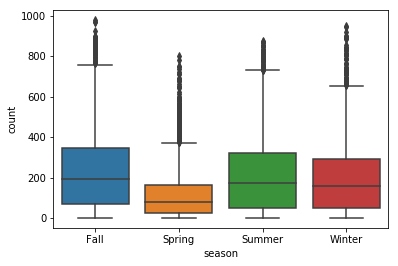

In [12]:
sn.boxplot(x = 'season', y = 'count', data = train) 

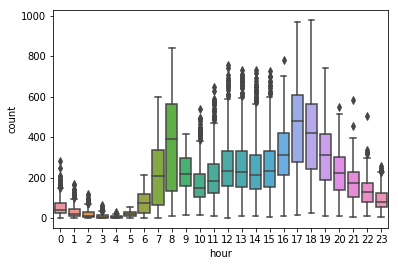

In [13]:
sn.boxplot(x = 'hour', y = 'count', data = train) 

In [15]:
train_outliers_stripped = train[np.abs(train["count"]-train["count"].mean()) <= (3*train["count"].std())]

Удалить выбросы из набора данных с помощью подхода описанного в https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame .

In [20]:
print ("Shape Of The Before Ouliers: ",train.shape)
print ("Shape Of The After Ouliers: ",train_outliers_stripped.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


# 5. Анализ корелляции

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


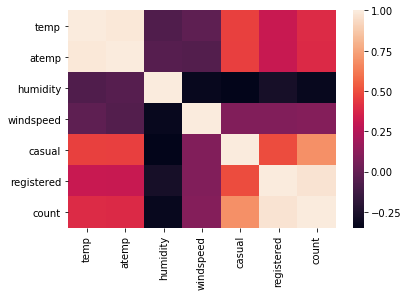

In [17]:
# Additional visualizations
correlations = train[["temp","atemp","humidity","windspeed","casual","registered", "count"]].corr()
display(correlations)


# Produce a heatmap
sn.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns)

Исходя из таблицы корелляции и тепловой карты выше, можно сделать следующие выводы: 
1. Высокая зависимость между переменными temp и atemp, что довольно логично, так как это фактическая и ощущаемая температура это  фактически одно и то же. Впоследствии можно будет удалить одну из этих колонок. 
2. Переменные registered и casual можно не рассматривать, так как это излишние данные, впоследствии можно будет эти колонки удалить. 
3. Переменная temp позивно кореллирует с count (целевой переменной) 
4. Переменная humidity отрицательно кореллирует с count  (целевой переменной) 
5. Исходя из графика переменная windspeed не кореллирует с count  (целевой переменной) 

# 6. Нормализация данных

Если данные как в нашем случае не распределены нормально, особенно если среднее и медианное значения значительно отличаются (обозначая очень значительный скос), обычно уместно применять нелинейное масштабирование. Один из способов - изпользование Box-Cox теста, который рассчитывает лучшее преобразование данных для уменьшения скоса. Более простой подход, который сработает в большинстве случаев, - это применение натурального логарифмирования. 

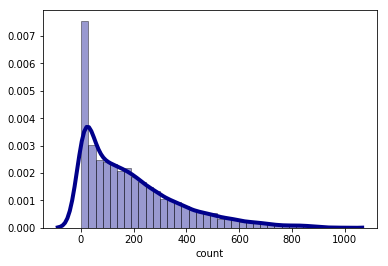

In [28]:
sn.distplot(train["count"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

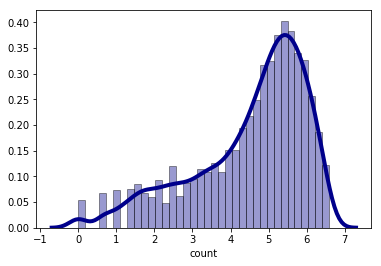

In [29]:
sn.distplot(np.log(train_outliers_stripped["count"]), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

# 7. Тестирование гипотез

In [56]:
hour_distr = train.groupby("hour")['count'].sum()
weather_distr = train.groupby("weather")['count'].sum()

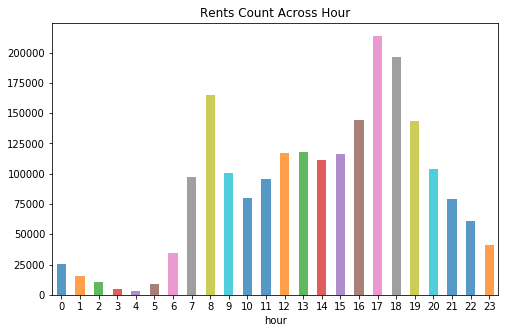

In [54]:
hour_distr.plot(kind="bar", figsize=(8,5),  title="Rents Count Across Hour" , alpha=0.75, rot=0, legend=False)

Из гистограммы видно, что наиболее популярное время для аренды - 7-8 часов утра и 5-7 часов вечера, что подтверждает изначальную гипототезу о "популярности" офисных часов

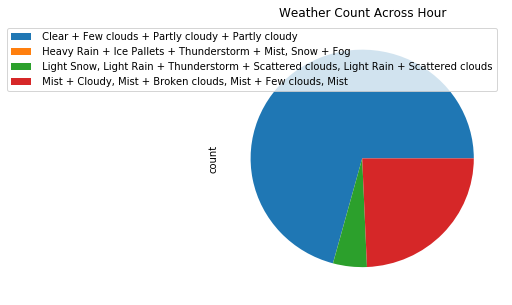

In [88]:
weather_distr.plot.pie(figsize=(5,5),  title="Weather Count Across Hour", legend=True, labels=None)

In [87]:
"""fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(weather_distr, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Ingredients",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Matplotlib bakery: A pie")

plt.show()"""

'fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))\n\nwedges, texts, autotexts = ax.pie(weather_distr, autopct=lambda pct: func(pct, data),\n                                  textprops=dict(color="w"))\n\nax.legend(wedges, ingredients,\n          title="Ingredients",\n          loc="center left",\n          bbox_to_anchor=(1, 0, 0.5, 1))\n\nplt.setp(autotexts, size=8, weight="bold")\n\nax.set_title("Matplotlib bakery: A pie")\n\nplt.show()'

Из гистограммы видно, что наиболее популярная погода для аренды - 7-8 часов утра и 5-7 часов вечера, что подтверждает изначальную гипототезу о "популярности" офисных часов